In [1]:
%reset
%matplotlib inline

import netCDF4 as nc
import cmocean
import numpy as np
import xarray as xr
import xrft
from xgcm import Grid
import matplotlib.pyplot as plt
import scipy.interpolate
from dask.diagnostics import ProgressBar
from matplotlib import colors, ticker
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20 #1/4 degree NeverWorld2 setup
run=28 #1/16 degree NeverWorld2 setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

#av1     = xr.open_dataset('run%i/averages_00030002.nc' % (run), decode_times=False)  #5-day average
#av2     = xr.open_dataset('run%i/averages_00030502.nc' % (run), decode_times=False)  #5-day average
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
#print(os)
plt.rcParams.update({'font.size': 18})

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [2]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/run33
run=33; factor = 1440/86400 #1/32 degree NeverWorld setup
fs=xr.open_dataset('static.nc', decode_times=False)
os=xr.open_dataset('ocean.stats.nc', decode_times=False)
forcing=xr.open_dataset('forcing_00002000.nc', decode_times=False)
init=xr.open_dataset('MOM_IC.nc', decode_times=False)
av=xr.open_dataset('averages_00001902.nc',decode_times=False)
#av=xr.open_mfdataset(['averages_00001502.nc','averages_00001602.nc', 'averages_00001702.nc', 'averages_00001802.nc', 'averages_00001902.nc'],decode_times=False,combine='by_coords')
# print(av)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/scratch/gmarques/NW2_TMP/run33
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
lat= (av.yh)     
lon= (av.xh)     

u= av.u[:,0,:,:]-(av.u[:,0,:,:].mean('time')); print('done')#We're removing the temporally-averaged mean flow.
v= av.v[:,0,:,:]-(av.v[:,0,:,:].mean('time'))

#u= xr.concat([av1.u[:,0,:,:],av2.u[:,0,:,:]],dim='time');#-(av.u[:,0,:,:].mean('time')) #We're removing the temporally-averaged mean flow.
#v= xr.concat([av1.v[:,0,:,:],av2.v[:,0,:,:]],dim='time');#-(av.v[:,0,:,:].mean('time'))
Ld = av.Rd1[:].mean('time')
grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
#Interpolating u,v to be on the same grid points:
dx= grid.interp(fs.dxCu,axis='X')
dy= grid.interp(fs.dyCv,axis='Y')
u = grid.interp(u,axis='X')
v = grid.interp(v,axis='Y')
print(u.shape,v.shape)
Ld = av.Rd1[:].mean('time')

done
(20, 4480, 1920) (20, 4480, 1920)


In [4]:
print('min dx:',2*np.pi*6378000*np.cos(70*np.pi/180)/360/16,'km')
print('max dx:',2*np.pi*6378000/360/16,'km')

min dx: 2379.543149457715 km
max dx: 6957.318730762397 km


In [5]:
# u.chunk({"time": 100})
# v.chunk({"time": 100})

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


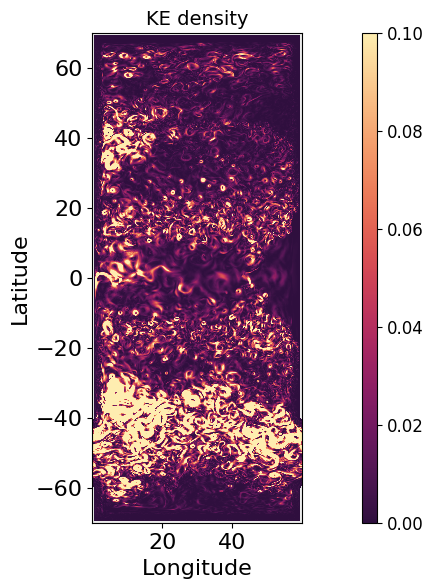

In [33]:
#Plotting KE for whole domain
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('KE density',fontsize=14)

KE=(u**2+v**2)*0.5
plotted =ax1.pcolor(lon,lat,KE[-1,:],cmap=cmocean.cm.matter_r,vmin=0,vmax=1e-1)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

In [6]:
u.shape

(20, 4480, 1920)

In [9]:
# for i in range(0,len(u[:,0,0])):
#     print(i)
uconc = []
vconc = []
dxconc= []

for i in range(0,20):#len(u[:,0,0]))\
    offset = 20*i-20
    dsu = u[i,:,640:-640].assign_coords(xh=u[i,:,640:-640].xh+offset)
    dsv = v[i,:,640:-640].assign_coords(xh=v[i,:,640:-640].xh+offset)
    dsdx= dx[:,640:-640]
    
    uconc.append(dsu)
    vconc.append(dsv)
    dxconc.append(dsdx)
    
uconc1 = (xr.concat(uconc, dim='xh'))#.chunk({"xh":25600})
vconc1 = (xr.concat(vconc, dim='xh'))#.chunk({"xh":25600})
dxconc= (xr.concat(dxconc, dim='xh'))#.chunk({"xh":25600})
interp_scale = dx[:,640:-640].sum('xh')

In [10]:
uconc1

<xarray.DataArray (yh: 4480, xh: 12800)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     (xh) float64 1.902e+03 1.902e+03 1.902e+03 ... 1.998e+03 1.998e+03
  * yh       (yh) float64 -69.98 -69.95 -69.92 -69.89 ... 69.92 69.95 69.98
  * xh       (xh) float64 0.01562 0.04688 0.07812 0.1094 ... 399.9 400.0 400.0

## We will now change the x-coordinates to be in units of meters rather than degrees.

(4480, 12800)


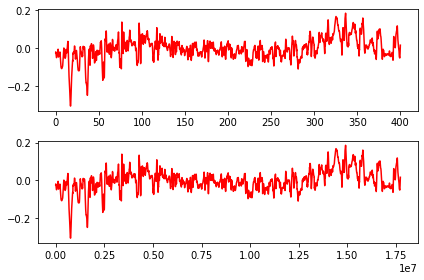

In [11]:
xi=dxconc.cumsum(axis=1)-dxconc[:,0] #subtract first dx so that we start at x=0m.
#xi=(xi-xi[:,479]) #Center the grid along the center longitude.


index=110
xline= xi[index,:]
uline1= uconc1[index,:]; uline1=uline1.assign_coords(xh=xline)
vline1= vconc1[index,:]; vline1=vline1.assign_coords(xh=xline)

print(xi.shape)

fig, ax = plt.subplots(2)
ax[0].plot(uconc1[index,:].xh,uconc1[index,:],'r')

ax[1].plot(xline,uline1,'r')
plt.tight_layout()

In [12]:
xi.shape

(4480, 12800)

### Computing the 1D spectrum at one latitude

In [13]:
%%time
i =300 #specifies latitude index
xline= xi[i,:]
uline1= uconc1[i,:]; uline1=uline1.assign_coords(xh=xline)
# uline2= uconc2[i,:]; uline2=uline2.assign_coords(xh=xline)
# uline3= uconc3[i,:]; uline3=uline3.assign_coords(xh=xline)
# uline4= uconc4[i,:]; uline4=uline4.assign_coords(xh=xline)
# uline5= uconc5[i,:]; uline5=uline5.assign_coords(xh=xline)

vline1= vconc1[i,:]; vline1=vline1.assign_coords(xh=xline)
# vline2= vconc2[i,:]; vline2=vline2.assign_coords(xh=xline)
# vline3= vconc3[i,:]; vline3=vline3.assign_coords(xh=xline)
# vline4= vconc4[i,:]; vline4=vline4.assign_coords(xh=xline)
# vline5= vconc5[i,:]; vline5=vline5.assign_coords(xh=xline)


CPU times: user 1.27 ms, sys: 95 µs, total: 1.36 ms
Wall time: 1.37 ms


In [14]:
%%time
Ldline= Ld[i,100:-100]; 
    
uiso2_1 = xrft.power_spectrum(uline1.chunk({"xh":128000}),dim=['xh'], scaling="spectrum",detrend='linear').compute() #, window='hann/hamming', detrend='linear'
# uiso2_2 = xrft.power_spectrum(uline2,dim=['xh'], scaling="spectrum",detrend='linear').compute() #, window='hann/hamming', detrend='linear'
# uiso2_3 = xrft.power_spectrum(uline3,dim=['xh'], scaling="spectrum",detrend='linear').compute() #, window='hann/hamming', detrend='linear'
# uiso2_4 = xrft.power_spectrum(uline4,dim=['xh'], scaling="spectrum",detrend='linear').compute() #, window='hann/hamming', detrend='linear'
# uiso2_5 = xrft.power_spectrum(uline5,dim=['xh'], scaling="spectrum",detrend='linear').compute() #, window='hann/hamming', detrend='linear'

viso2_1 = xrft.power_spectrum(vline1.chunk({"xh":128000}),dim=['xh'], scaling="spectrum",detrend='linear').compute() #, window='hann/hamming', detrend='linear'
# viso2_2 = xrft.power_spectrum(vline2,dim=['xh'], scaling="spectrum",detrend='linear').compute() #, window='hann/hamming', detrend='linear'
# viso2_3 = xrft.power_spectrum(vline3,dim=['xh'], scaling="spectrum",detrend='linear').compute() #, window='hann/hamming', detrend='linear'
# viso2_4 = xrft.power_spectrum(vline4,dim=['xh'], scaling="spectrum",detrend='linear').compute() #, window='hann/hamming', detrend='linear'
# viso2_5 = xrft.power_spectrum(vline5,dim=['xh'], scaling="spectrum",detrend='linear').compute() #, window='hann/hamming', detrend='linear'

ekeiso1 = .5*(uiso2_1 + viso2_1)
# ekeiso2 = .5*(uiso2_2 + viso2_2)
# ekeiso3 = .5*(uiso2_3 + viso2_3)
# ekeiso4 = .5*(uiso2_4 + viso2_4)
# ekeiso5 = .5*(uiso2_5 + viso2_5)
nk = int(len(ekeiso1)/2.)

ekeiso=(ekeiso1)#+ekeiso2+ekeiso3+ekeiso4+ekeiso5)/5.
ekeiso=ekeiso[nk+1:]    # half of the latitude array size
wavenumber= (ekeiso.freq_xh*1e3*2*np.pi)
LD_wavenumber=(1/(Ldline/1000)).mean('xh')
ES_wavenumber=ekeiso[10:].idxmax(dim='freq_xh')*1000*2*np.pi #don't count first 3 wavenumbers
concat_wavenumber=(1/(interp_scale[index]/1000))

    
# alt_PS=0.5*(np.abs(np.fft.rfft(uline))**2)+0.5*(np.abs(np.fft.rfft(vline))**2)
# alt_PS=alt_PS/(int(len(xline)/2)**2)
# alt_freq= np.fft.rfftfreq(uline.size,np.array(dx[i,100])/(1000*2*np.pi))

CPU times: user 41.8 ms, sys: 6.37 ms, total: 48.1 ms
Wall time: 130 ms


Text(0, 0.5, '[m$^2$ s$^{-2}$]')

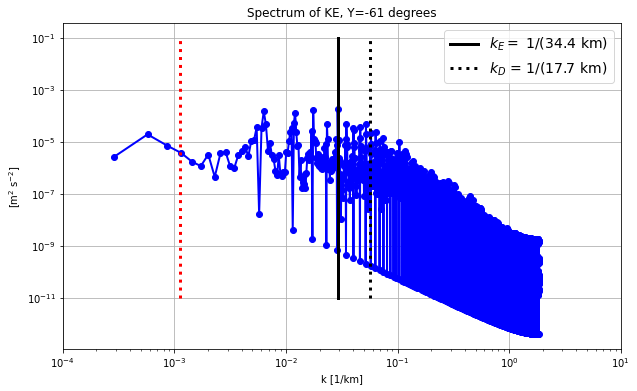

In [15]:
fig, ax = plt.subplots(figsize=(10,6))


#plt.plot(alt_freq[1:],alt_PS[1:],'-or',linewidth=2)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber
plt.plot(wavenumber,ekeiso,'-bo',linewidth=2)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber

l1=plt.plot([ES_wavenumber,ES_wavenumber], [1e-11,1e-1],color='k',linewidth=3,label='$k_E=$ 1/(%.1f km)'%(1/ES_wavenumber))
l2=plt.plot([LD_wavenumber,LD_wavenumber], [1e-11,1e-1],':k',linewidth=3,label='$k_D$ = 1/(%.1f km)'%(1/LD_wavenumber))
l3=plt.plot([concat_wavenumber,concat_wavenumber], [1e-11,1e-1],':r',linewidth=3)

plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE, Y=%.0f degrees'%lat[i])
#plt.ylim([1e-5, 1e5])
plt.xlim([1e-4, 1e1])
plt.grid()
plt.xlabel('$\kappa_r (1/km)$')
plt.legend(fontsize=14)

ax.set_xlabel(r'k [1/km]')
ax.set_ylabel(r'[m$^2$ s$^{-2}$]')

In [17]:
LD_wavenumber=Ld[40:-40,0]*0.0
ES_wavenumber=Ld[40:-40,0]*0.0
concat_wavenumber=Ld[40:-40,0]*0.0



for i in range(40,len(lat)-40):#,len(lat)):

    xline= xi[i,:]
    uline1= uconc1[i,:]; uline1=uline1.assign_coords(xh=xline)

    vline1= vconc1[i,:]; vline1=vline1.assign_coords(xh=xline)


    Ldline= Ld[i,640:-640]; 
    
    uiso2_1 = xrft.power_spectrum(uline1,dim=['xh'], scaling="spectrum",detrend='linear').compute() #, window='hann/hamming', detrend='linear'

    viso2_1 = xrft.power_spectrum(vline1,dim=['xh'], scaling="spectrum",detrend='linear').compute() #, window='hann/hamming', detrend='linear'

    ekeiso1 = .5*(uiso2_1 + viso2_1)

    nk = int(len(ekeiso1)/2.)

    ekeiso=(ekeiso1)#+ekeiso2+ekeiso3+ekeiso4+ekeiso5)/5.
    ekeiso=ekeiso[nk+1:]    # half of the latitude array size
    wavenumber= (ekeiso.freq_xh*1e3*2*np.pi)
    LD_wavenumber[i-40]=(1/(Ldline/1000)).mean('xh')
    ES_wavenumber[i-40]=ekeiso[10:].idxmax(dim='freq_xh')*1000*2*np.pi #don't count first 3 wavenumbers
    concat_wavenumber[i-40]=(1/(interp_scale[index]/1000))

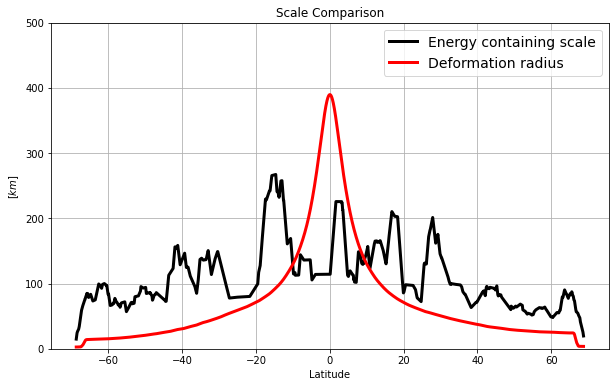

In [18]:
fig, ax = plt.subplots(figsize=(10,6))


window=100
a=np.convolve(1./ES_wavenumber, np.ones((window,))/window, mode='same')
#plt.plot(ES_wavenumber.yh,1./ES_wavenumber,'-',c='k',linewidth=3,label='Energy containing scale')
plt.plot(ES_wavenumber.yh,a,'-',c='k',linewidth=3,label='Energy containing scale')

plt.plot(LD_wavenumber.yh,1./LD_wavenumber,'-',c='r',linewidth=3,label='Deformation radius')
#plt.fill_between(ES_wavenumber.yh, 1./(ES_wavenumber)+ES_stdev, 1./(ES_wavenumber)-ES_stdev,color=(0.5,0.5,0.5,0.5))

plt.title('Scale Comparison')
plt.ylim([0, 500])
#plt.xlim([-70, 70])
plt.grid()
plt.xlabel('Latitude'); plt.ylabel('$[km]$');
plt.legend(fontsize=14)

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

In [19]:
# #COMPUTE velocity components for decomposing KE:
Nlayers=15

h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(20, 15, 4480, 1920)


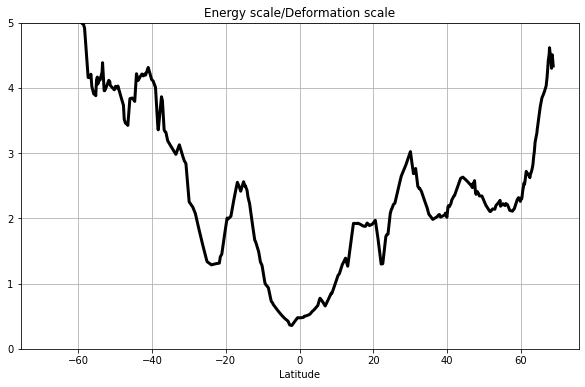

In [40]:
fig, ax = plt.subplots(figsize=(10,6))


 
window=240
a=np.convolve(1./ES_wavenumber, np.ones((window,))/window, mode='same')
b=np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same')
c = np.convolve(LD_wavenumber/ES_wavenumber,np.ones((window,))/window,mode='same')

#plt.plot(ES_wavenumber.yh,c,'-',c=[.7,.7,.7],linewidth=3,label='Energy containing scale')
plt.plot(ES_wavenumber.yh,(a/b),'-',c='k',linewidth=3,label='Energy containing scale')

#plt.plot(u_small.y5km/1000,np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same'),'-',c='r',linewidth=3,label='Energy containing scale')
#





plt.title('Energy scale/Deformation scale')
plt.ylim([0, 5])
#plt.xlim([-6500, 6500])
plt.grid()
plt.xlabel('Latitude'); 
#plt.ylabel('$[km]$');

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

In [20]:
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x


#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot=KE_eddy_BT+KE_mean_BT
KE_BC_tot=KE_eddy_BC+KE_mean_BC
KE_tot=KE_BT_tot+KE_BC_tot


fraction_BT=KE_BT_tot/KE_tot
fraction_BT_mean=KE_mean_BT/KE_tot
fraction_BT_eddy=KE_eddy_BT/KE_tot

fraction_BC=KE_BC_tot/KE_tot#when you divide zero/zero it's a nan
fraction_BC_mean=KE_mean_BC/KE_tot
fraction_BC_eddy=KE_eddy_BC/KE_tot

KE_eddy = KE_eddy_BT+ KE_eddy_BC
KE_mean = KE_mean_BT+ KE_eddy_BC

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Text(0.5, 1.0, '1/32$^\\circ$ BT/BC KE fractions')

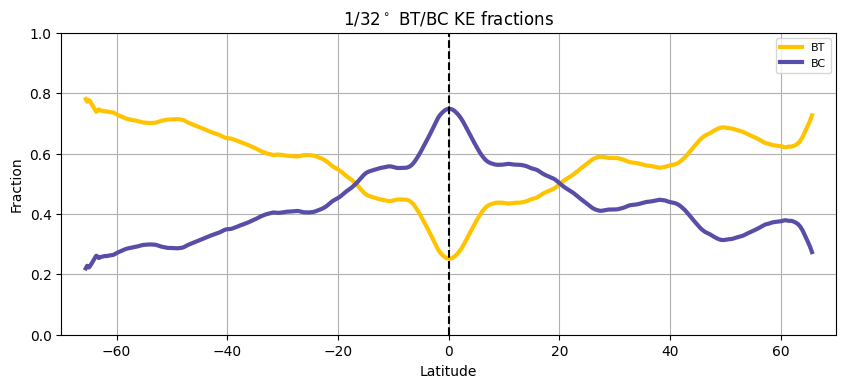

In [21]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=240

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(fraction_BT.yh,np.convolve(np.nanmean(fraction_BT,axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)
plt.grid()
plt.plot(fraction_BC.yh,np.convolve(np.nanmean(fraction_BC,axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)

plt.legend(['BT','BC'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-70, 70)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/32$^\circ$ BT/BC KE fractions')

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Text(0.5, 1.0, '1/32$^\\circ$ BT/BC EKE fractions')

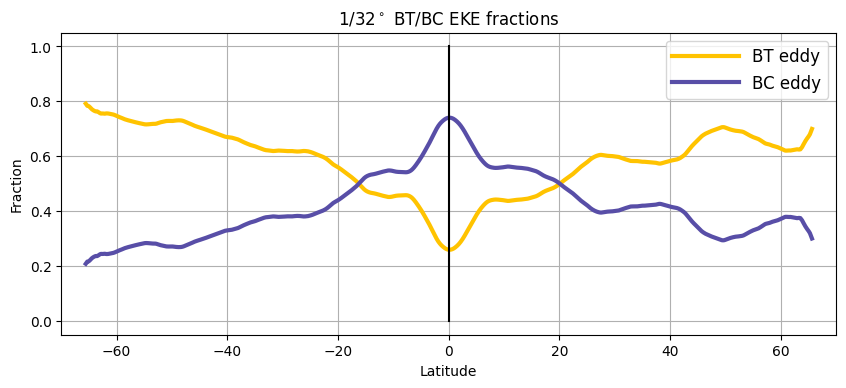

In [22]:
window=240

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(fraction_BT.yh,np.convolve(np.nanmean(KE_eddy_BT/KE_eddy,axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)

plt.grid()
plt.plot(fraction_BT.yh,np.convolve(np.nanmean(KE_eddy_BC/KE_eddy,axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)


plt.legend(['BT eddy','BC eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70)
#plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/32$^\circ$ BT/BC EKE fractions')

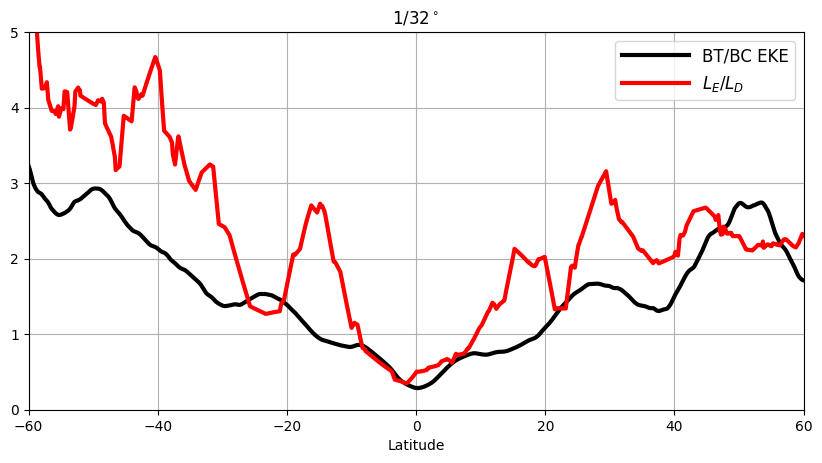

In [38]:
window=200

plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
yh_center=av.yh[40:-40]
Eddy_BC=(KE_eddy_BC.mean('xh'))[40:-40];
Eddy_BT=(KE_eddy_BT.mean('xh'))[40:-40];

BT_BC=np.convolve((Eddy_BT/Eddy_BC), np.ones((window,))/window, mode='same')
LE_LD=np.convolve((LD_wavenumber/ES_wavenumber), np.ones((window,))/window, mode='same')

bound1=100; bound2=-100
plt.plot(yh_center[bound1:bound2],BT_BC[bound1:bound2],'-',c='k',linewidth=3)

plt.plot(yh_center[bound1:bound2],LE_LD[bound1:bound2],'-',c='r',linewidth=3)


plt.legend(['BT/BC EKE','$L_E/L_D$'],loc='upper right',fontsize=12,handlelength=4)
#plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-60, 60)
plt.ylim(0,5);
plt.xlabel('Latitude')
#plt.ylabel('Fraction')
plt.title('1/32$^\circ$')
plt.grid()

Text(0.5, 1.0, 'Lat.')

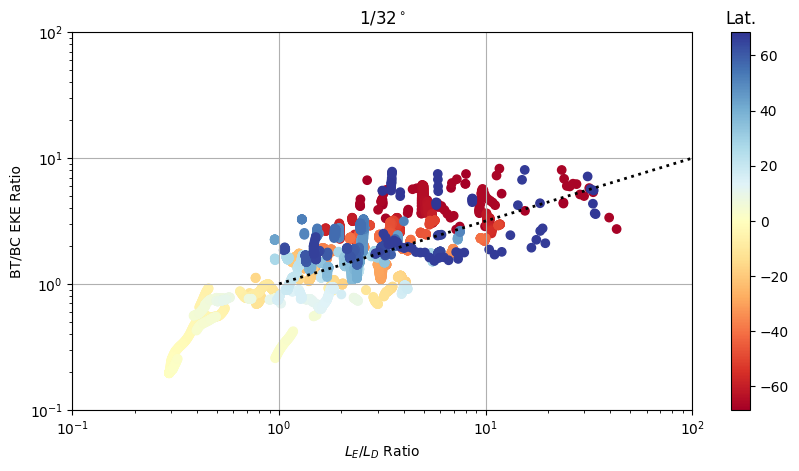

In [45]:

plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
yh_center=av.yh[40:-40]
Eddy_BC=(KE_eddy_BC.mean('xh'))[40:-40];
Eddy_BT=(KE_eddy_BT.mean('xh'))[40:-40];
BT_BC=(Eddy_BT/Eddy_BC)
LE_LD=(LD_wavenumber/ES_wavenumber)

bound1=10; bound2=-10
plt.scatter(LE_LD[bound1:bound2]**1,BT_BC[bound1:bound2],c=yh_center[bound1:bound2], cmap='RdYlBu')


#plt.xlim(0,5)
#plt.ylim(0,5);
plt.ylim([1e-1, 1e2])
plt.xlim([1e-1, 1e2])
plt.xscale('log')
plt.yscale('log')

plt.plot([1e0,1e2],[1e0,1e1],':k',linewidth=2)
plt.ylabel('BT/BC EKE Ratio')
plt.xlabel('$L_E/L_D$ Ratio')
plt.title('1/32$^\circ$')
plt.grid()
clb=plt.colorbar()
clb.ax.set_title('Lat.',fontsize=12)